<a href="https://colab.research.google.com/github/williserdman/Radar-Material-Detection-Exploration/blob/main/roast_level_bean_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A coffee bean analysis

In [ ]:
import numpy as np
import h5py

In [ ]:
%%capture # suppress output of this cell
%pip install acconeer-exptool
from acconeer.exptool import a121

# Loading the Data
The data comes from acconeer's collection tool and has a lot of metadata about the config settings and otherwise to how the data was collected. This is important in ensuring that all data is collected in the same manner, however, when it comes to machine learning it will all be identical so matters little to us.

Although Acconeer has little documentation I was able to find an example of there's where they used some machine learning and was able to extrapolate their data processing to here. The following function takes their record data and converts it into a large numpy array. In the array, the second dimension is arrays for each frame/scan that the sensor conducted and simply the amplitude at each step.

In [ ]:
def process_h5(record):
  data = []
  for elm in record.extended_stacked_results:
    dframe = [elm[key].frame for key in elm.keys()]
    dframe = np.array(dframe)
  return np.squeeze(abs(dframe))

In [ ]:
# loading the data

green_record = a121.load_record("green.h5")
medium_record = a121.load_record("medium_roast.h5")
dark_record = a121.load_record("pikes_roasted.h5")

# Feature extraction
This is perhaps the most important part of this data exploration. I began with simply the first two peaks and the ratio between them which was loosly based on Acconeer's material classification paper. While they used the mean over time I simplified this and simply made the classifications based on a single frame of the radar's reading.

Through further analysis I've gone on to add the standard deviation, the mean of the frame, and the area under the curve for my models to work with. Later we will see that these are likely being used by the models.

In [ ]:
from scipy.signal import find_peaks
import statistics
def feature_extraction(test_data):
  data = []
  for i in test_data:
    # this is getting the first and second peaks (from cup detection)
    peaks, _ = find_peaks(i)
    sorted_peaks = peaks[np.argsort(i[peaks])][::-1]
    top_two_peaks = sorted_peaks[:2]
    features = i[top_two_peaks].tolist()

    # adding the ratio of the two peaks to the features
    features.append(top_two_peaks[0] / top_two_peaks[1])

    # adding the standard deviation of the peaks to the features
    features.append(statistics.stdev(i))

    # adding the mean of the peaks to the features
    features.append(statistics.mean(i))

    # adding the area under the curve to the features
    features.append(np.trapz(i))

    # adding that datapoint to the list
    data.append(features)
  return data, len(data)

In [ ]:
md, ml = feature_extraction(process_h5(medium_record))
dd, dl = feature_extraction(process_h5(dark_record))
gd, gl = feature_extraction(process_h5(green_record))

data = md + dd + gd
labels = ["medium"] * ml + ["dark"] * dl + ["green"] * gl

In [ ]:
len(data), len(labels)

(706, 706)

In [ ]:
data = np.array(data)
labels = np.array(labels)

# Trees and forests
Typically one would start with a single tree before moving onto a random forest. However, not knowing how easily this would go I decided to first start with a random forest. However the results of the random forest are harder to interpret than those of the single decision tree that I followed up with.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


## Decision tree
The decision tree is a good way for us to begin to understand what the models are looking at. Currently the classification is using the standard deviation and area under the curve to predict how the bean should be classified. As mentioned briefly above these were determined to be important traits.

Previously when only (peak 1, peak 2, p1:p2) was availible the peak 1 was the only datapoint that the decision tree needed to make a distinction. Considering that accuracy **even with only one data point** was 100% it's hard for us to say for certain that stdev or area under the curve is more important.

In [ ]:
single_tree = tree.DecisionTreeClassifier()
single_tree.fit(X_train, y_train)

single_y_pred = single_tree.predict(X_test)
single_accuracy = accuracy_score(y_test, single_y_pred)
print(f'Accuracy: {single_accuracy}')

Accuracy: 1.0


[Text(0.4, 0.8333333333333334, 'x[5] <= 5584.313\ngini = 0.663\nsamples = 564\nvalue = [211, 165, 188]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 211\nvalue = [211, 0, 0]'),
 Text(0.6, 0.5, 'x[3] <= 46.364\ngini = 0.498\nsamples = 353\nvalue = [0, 165, 188]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 165\nvalue = [0, 165, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 188\nvalue = [0, 0, 188]')]

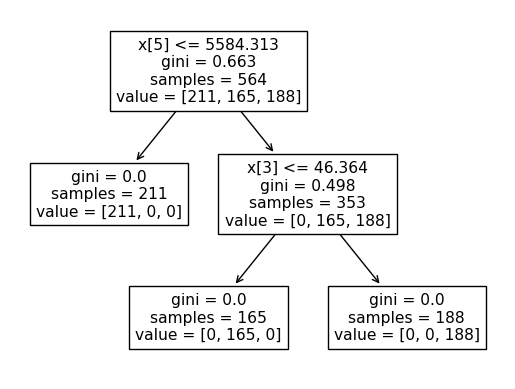

In [ ]:
tree.plot_tree(single_tree)

In [ ]:
# helper function

def tree_pred_from_file(filename):
  record = a121.load_record(filename)
  data, _ = feature_extraction(process_h5(record))
  return single_tree.predict(data)

# Clustering
This is perhaps not the best approach to this data. Knowing that it's classified data what we can get from this is insight into the data.

## K means
Most of this is going through the motions of setting up clusters and searching for the right number of clusters to make. In reality I know there are three different classifications. However, when graphed its interesting to see the relationship between variables in the dataset. Here we see the poorest accuracy of any method.

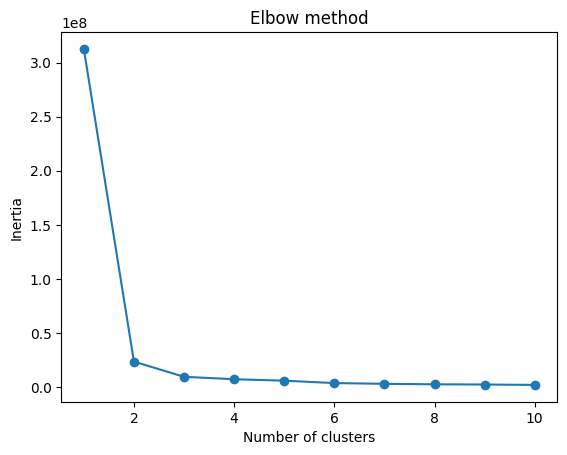

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init="auto")
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

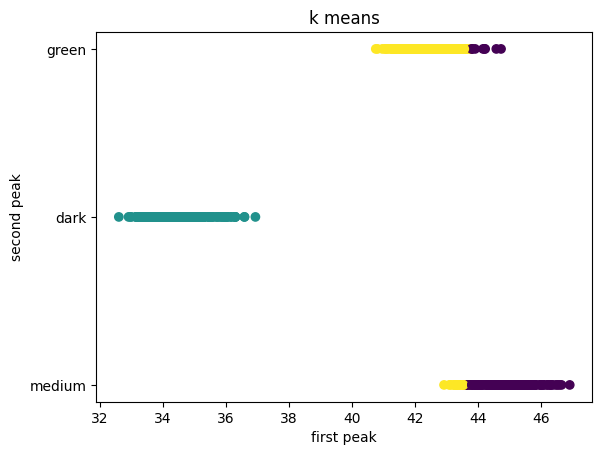

In [ ]:
kmeans = KMeans(n_clusters=3, n_init="auto")
kmeans.fit(X_train)

#plt.scatter([x[0] for x in X_train], [x[2] for x in X_train], c=kmeans.labels_)
plt.scatter([x[4] for x in X_train], y_train, c=kmeans.labels_)
plt.title("k means")
plt.xlabel("first peak")
plt.ylabel("second peak")
plt.show()

In [ ]:
preds = kmeans.predict(X_test)
labels = ["dark", "medium", "green"]
accuracy_score([labels[p] for p in preds], y_test)

0.9577464788732394

## K Nearest Neighbors
This is perhaps a more viable approach to clustering and classification for this application than kmeans. Here we do see good accuracy. It's leading me to the insight that perhaps for this application the 2nd peak and ratio between the two peaks isn't really that helpful, however, it will be left for now b/c "if it ain't broke don't fix it."

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
prediction = knn.predict(X_test)
accuracy_score(prediction, y_test)

1.0

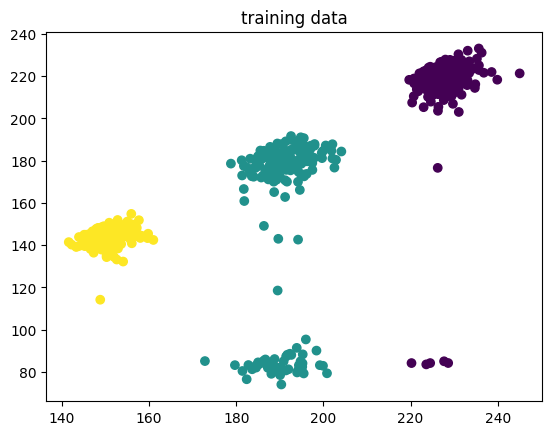

In [ ]:
y_train_copy = y_train.copy()
y_train_copy[y_train_copy == "medium"] = 1
y_train_copy[y_train_copy == "dark"] = 2
y_train_copy[y_train_copy == "green"] = 3
y_train_copy = [eval(i) for i in y_train_copy.tolist()]
plt.scatter([x[0] for x in X_train], [x[1] for x in X_train], c=y_train_copy)
plt.title("training data")
plt.show()

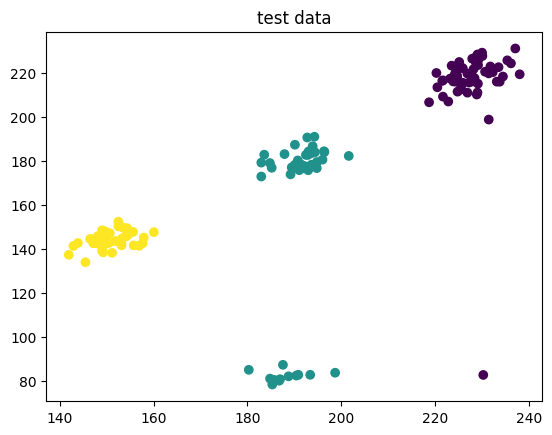

In [ ]:
prediction_copy = prediction.copy()
prediction_copy[prediction_copy == "medium"] = 1
prediction_copy[prediction_copy == "dark"] = 2
prediction_copy[prediction_copy == "green"] = 3
prediction_copy = [eval(i) for i in prediction_copy.tolist()]
plt.scatter([x[0] for x in X_test], [x[1] for x in X_test], c=prediction_copy)
plt.title("test data")
plt.show()

# Nerual network
Kind of the magic to classifying this it works rather as expcted. This is an application for going forward, as, at this point in time other simpler solutions have perfect accuracy it does not make sense to use a neural network.

In [ ]:
%%capture
%pip install fastai

from fastai.tabular.all import *
import pandas as pd

## Collab data visualization
Appearently I should have thrown everything into a dataframe earlier as collab offers a button "show recommended plots" which creates like 20 plots comparing features of the data and it's a very very easy way to see what could be important.

In [ ]:
df_train = pd.DataFrame(X_train, columns=['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral"])
df_train['label'] = y_train

cat_names = []
cont_names = ['peak 1', 'peak 2', 'peak1:peak2 ratio', "stdev", "mean", "integral"]
dep_var = 'label'

# Show the DataFrame
df_train.head()

,peak 1,peak 2,peak1:peak2 ratio,stdev,mean,integral,label
0,225.523835,221.774660,0.974684,52.940082,44.679237,6426.789356,medium
1,226.291847,203.629566,1.040000,52.955109,44.351357,6376.050649,medium
2,188.788241,86.052310,0.804348,42.801665,34.055255,4890.005503,dark
3,186.681547,85.866175,0.787234,42.050743,34.578524,4965.905711,dark
4,146.164291,145.206749,1.042254,40.067023,42.250708,6078.992152,green


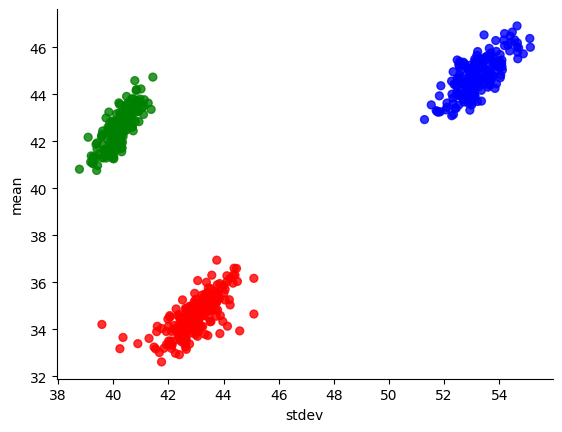

In [ ]:
# @title stdev vs mean
# google didnt provide the colors but once added its clear that clustering would have worked splendidly with these two data points

color_map = {'dark': 'red', 'medium': 'blue', 'green': 'green'}

from matplotlib import pyplot as plt
df_train.plot(kind='scatter', x='stdev', y="mean", s=32, alpha=.8, c=df_train["label"].map(color_map))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Training
Trained without any hiccups just using the default settings. While I could have fine tuned this more again it was mostly just to have the framework for further analysis later down the line.

In [ ]:
# Create TabularPandas object
dls = TabularDataLoaders.from_df(df_train, y_names=dep_var, cat_names=cat_names, cont_names=cont_names, procs=[Categorify, Normalize])

# Define the model
learn = tabular_learner(dls, metrics=accuracy)

# Train the model
learn.fit(10)

# Evaluate the model
learn.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.382722,0.737989,0.910714,00:00
1,0.211539,0.352399,1.000000,00:00
2,0.142468,0.128327,1.000000,00:00
3,0.106261,0.049609,1.000000,00:00
4,0.083763,0.021668,1.000000,00:00
5,0.068826,0.012978,1.000000,00:00
6,0.056825,0.009269,1.000000,00:00
7,0.047283,0.006449,1.000000,00:00
8,0.040159,0.005022,1.000000,00:00
9,0.034397,0.004360,1.000000,00:00


,peak 1,peak 2,peak1:peak2 ratio,label,label_pred
0,-0.212155,0.187410,-0.077140,0.0,0.0
1,1.330474,1.012208,-0.408109,2.0,2.0
2,1.186569,0.999132,-0.237614,2.0,2.0
3,-0.094981,-2.034820,-2.506818,0.0,0.0
4,-1.215665,-0.950358,1.566465,1.0,1.0
5,0.123457,-0.002649,-0.077140,0.0,0.0
6,0.148139,0.164733,-0.077140,0.0,0.0
7,1.402636,1.306208,0.673127,2.0,2.0
8,-0.101047,-0.061657,-0.077140,0.0,0.0
